# 傾向スコアマッチングにおけるモデル選択法を考える

## モジュールインポート

In [243]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, log_loss, precision_score, recall_score, accuracy_score, average_precision_score
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import japanize_matplotlib

## 関数定義

In [330]:
def generate_data_for_ps_matching(random_seed: int, data_size: int, true_att: float):
    '''効果検証対象となるデータを作成する
    Args:
        random_seed (int)  : 乱数のシード値
        data_size   (int)  : データの行数
        true_att    (float):真のATT

    Returns:
        df: 効果検証対象となるデータフレーム
            ├X1      : 特徴量1（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X2      : 特徴量2（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X3      : 特徴量3（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X4      : 特徴量4（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├X5      : 特徴量5（サイト回遊意欲・購入意欲の高さを示す交絡因子）
            ├T       : 介入有無
            ├Y_past  : 観測される目的変数（過去）
            ├Y       : 観測される目的変数
            ├true_ps : 真の傾向スコア
            ├Y0      : 介入されなかった場合の目的変数
            └Y1      : 介入された場合の目的変数
    '''
    # シードを固定
    np.random.seed(random_seed)
    
    # サンプルサイズ
    N = data_size
    
    # 共変量Xを生成（さらに複雑な分布を使用）
    X1 = np.random.normal(0, 1, N) + 0.5 * np.random.normal(0, 1, N)  # ノイズ追加
    X2 = np.random.gamma(shape=2, scale=2, size=N) - 1.5  # 非対称な分布
    X3 = np.random.binomial(1, 0.5, N)
    X4 = np.sin(X1) + np.random.normal(0, 0.2, N)  # 非線形要素
    X5 = (X2 > np.median(X2)).astype(int)  # 二値変数
    
    # 傾向スコアの非線形関数（ロジスティック関数ではなく、シグモイド＋サイン波を混ぜる）
    base_ps = 0.5 * (np.sin(X1 * X2) + 1) * (1 / (1 + np.exp(-0.5 * X3 + 0.3 * X4 - 0.4 * X5))) + np.random.normal(0, 0.1, N)

    # 不均衡を加える（処置群の割合を変動させる）
    imbalance_ratio = 1.5
    adjusted_ps = imbalance_ratio * base_ps + (1 - imbalance_ratio) * (1 - base_ps)
    
    # 0〜1の範囲に収める（確率なので）
    true_ps = np.clip(adjusted_ps, 0.05, 0.95)
    
    # 処置変数 T（確率的に割り当て）
    T = np.random.binomial(1, true_ps, N)
    
    # 潜在的結果（Y0: 控除群, Y1: 処置群）
    Y_past = 3 + 0.7 * X1 - 0.5 * X2 + 0.3 * X3 + 0.4 * X4 - 0.2 * X5 + np.random.normal(0, 1.5, N)
    ATT = true_att  # 真のATT
    Y1 = Y_past + ATT + np.random.normal(0, true_att*0.1 , N)
    Y0 = Y_past       + np.random.normal(0, true_att*0.1 , N)
    
    # 観測される結果
    Y = np.where(T == 1, Y1, Y0)
    
    # データフレーム作成
    df = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5,
        'T': T,
        'Y_past': Y_past,
        'Y': Y,
        'true_ps': true_ps,
        'Y0': Y0,
        'Y1': Y1
    })
        
    return df

In [331]:
def return_pscore_by_logistic_regression(df: pd.DataFrame):
    '''効果検証対象となるデータから、ロジスティック回帰にて傾向スコアを得る
    Args:
        df (pd.DataFrame): 効果検証対象となるデータ

    Returns:
        pscore: ロジスティック回帰により得られた傾向スコア
    '''
    # 共変量のカラムを指定する
    x_columns = [col for col in df.columns if col.startswith('X')]
    # ロジスティック回帰で傾向スコアを推定
    logit_model = LogisticRegression()
    logit_model.fit(df[x_columns], df['T'])
    pscore = logit_model.predict_proba(df[x_columns])[:, 1]

    return pscore

In [332]:
def return_pscore_by_gbm(df: pd.DataFrame):
    '''効果検証対象となるデータから、勾配ブースティング木にて傾向スコアを得る
    Args:
        df (pd.DataFrame): 効果検証対象となるデータ

    Returns:
        pscore: 勾配ブースティング木により得られた傾向スコア
    '''
    # 共変量のカラムを指定する
    x_columns = [col for col in df.columns if col.startswith('X')]
    # 勾配ブースティング木で傾向スコアを推定
    gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbm_model.fit(df[x_columns], df['T'])
    pscore = gbm_model.predict_proba(df[x_columns])[:, 1]

    return pscore

In [333]:
# 傾向スコアモデルの評価関数
def evaluate_ps_model(df: pd.DataFrame, pscore_column: str):
    """傾向スコアモデルの評価指標を計算する

    Args:
        df               (pd.DataFrame): 効果検証対象となるデータ
        pscore_column    (str)         : 傾向スコアのカラム名

    Returns:
        dict: モデルの評価指標（AUC, ロジ損失, 正解率, 適合率, 再現率, PR-AUC）
    """
    # 予測確率を基に閾値 0.5 でクラス分類
    predicted_T = (df[pscore_column] >= 0.5).astype(int)

    # 評価指標を計算
    auc_score = roc_auc_score(df['T'], df[pscore_column])
    log_loss_score = log_loss(df['T'], df[pscore_column])
    accuracy = accuracy_score(df['T'], predicted_T)
    precision = precision_score(df['T'], predicted_T, zero_division=0)
    recall = recall_score(df['T'], predicted_T, zero_division=0)
    pr_auc = average_precision_score(df['T'], df[pscore_column])

    # 結果を返す
    return {
        'AUC': auc_score,
        'Log Loss': log_loss_score,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'PR-AUC': pr_auc
    }

In [334]:
def return_matched_df(df: pd.DataFrame, pscore_column: str):
    """傾向スコアマッチングを行う

    Args:
        df               (pd.DataFrame): 効果検証対象となるデータ
        pscore_column    (str)         : 傾向スコアのカラム名

    Returns:
        matched_df: マッチング後のデータ
    """
    # 最近傍マッチングによるATT推定
    treated = df[df['T'] == 1].copy()
    control = df[df['T'] == 0].copy()
    
    # 1対1最近傍マッチング（傾向スコアに基づく）
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[[pscore_column]])
    distances, indices = nbrs.kneighbors(treated[[pscore_column]])
    
    # マッチングされた対を取得
    matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
    matched_treated = treated.reset_index(drop=True)
    # マッチング後のデータセットを作成
    matched_df = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

    return matched_df

In [335]:
def return_att(matched_df: pd.DataFrame):
    """ATTを推定する

    Args:
        matched_df(pd.DataFrame): マッチング後のデータ

    Returns:
        att_hat: 推定されたATT
    """
    att_hat = (matched_df[matched_df['T']==1]['Y'].values - matched_df[matched_df['T']==0]['Y'].values).mean()
    return att_hat

In [336]:
def compute_smd(df):
    """標準化平均差 (SMD) を計算する関数
    
    Args:
        df          (pd.DataFrame): データフレーム
        covariates  (list): 共変量のリスト
    
    Returns:
        pd.DataFrame: SMD のデータフレーム
    """
    smd_results = {}
    treated = df[df['T'] == 1]
    control = df[df['T'] == 0]

    covariates = [col for col in df.columns if col.startswith('X')]
    for covariate in covariates:
        mean_t = treated[covariate].mean()
        mean_c = control[covariate].mean()
        std_t = treated[covariate].std()
        std_c = control[covariate].std()

        smd = abs(mean_t - mean_c) / np.sqrt((std_t**2 + std_c**2) / 2)
        smd_results[covariate] = smd

    return pd.DataFrame.from_dict(smd_results, orient='index', columns=['SMD'])

In [337]:
def plot_smd(before_smd_df: pd.DataFrame, after_smd_df: pd.DataFrame):
    """標準化平均差 (SMD) を描画する関数
    
    Args:
        before_smd(pd.DataFrame): マッチング前のSMD
        after_smd (pd.DataFrame): マッチング後のSMD
    """
    # SMDを横向きの散布図で可視化
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # 横向きの散布図を作成
    ax.scatter(before_smd_df['SMD'], before_smd_df.index, label='Before Matching', color='skyblue'  , marker='o', alpha=0.7)
    ax.scatter(after_smd_df['SMD'] , after_smd_df.index, label='After Matching'  , color='lightpink', marker='s', alpha=0.7)
    
    # 閾値線（0.1）を追加
    ax.axvline(x=0.1, color='black', linestyle='--', label='Threshold (0.1)')
    
    # 軸ラベルとタイトル
    ax.set_xlabel("Standardized Mean Difference (SMD)")
    ax.set_ylabel("Covariates")
    ax.set_title("SMD Before and After Matching (1:1 Nearest Neighbor)")
    ax.legend()
    ax.invert_yaxis()

    # グラフを表示
    plt.show()

## ロジスティック回帰と勾配ブースティング木それぞれを用いた傾向スコアマッチングの精度を比較する

In [327]:
n_trials = 100
data_size=10000
true_att=0.5
avg_att_hat_list = []
std_att_hat_list = []
avg_accuracy_list = []
std_accuracy_list = []
avg_precision_list = []
std_precision_list = []
avg_recall_list = []
std_recall_list = []

att_hat_list = []
evaluate_dict_list = []
for i in tqdm(range(n_trials)):
    df = generate_data_for_ps_matching(random_seed=i, data_size=data_size, true_att=true_att)
    df['pscore'] = return_pscore_by_logistic_regression(df=df)
    evaluate_dict = evaluate_ps_model(df=df, pscore_column='pscore')
    evaluate_dict_list.append(evaluate_dict)
    matched_df = return_matched_df(df=df, pscore_column='pscore')
    att_hat = return_att(matched_df)
    att_hat_list.append(att_hat)

avg_att_hat_list.append(np.array(att_hat_list).mean())
std_att_hat_list.append(np.array(att_hat_list).std())
evaluate_df = pd.DataFrame(evaluate_dict_list)
summary_stats = {'mean': evaluate_df.mean().to_dict(), 'std': evaluate_df.std().to_dict()}
avg_accuracy_list.append(summary_stats['mean']['Accuracy'])
std_accuracy_list.append(summary_stats['std']['Accuracy'])
avg_precision_list.append(summary_stats['mean']['Precision'])
std_precision_list.append(summary_stats['std']['Precision'])
avg_recall_list.append(summary_stats['mean']['Recall'])
std_recall_list.append(summary_stats['std']['Recall'])

att_hat_list = []
for i in tqdm(range(n_trials)):
    df = generate_data_for_ps_matching(random_seed=i, data_size=data_size, true_att=true_att)
    df['pscore'] = return_pscore_by_gbm(df=df)
    evaluate_dict = evaluate_ps_model(df=df, pscore_column='pscore')
    evaluate_dict_list.append(evaluate_dict)
    matched_df = return_matched_df(df=df, pscore_column='pscore')
    att_hat = return_att(matched_df)
    att_hat_list.append(att_hat)

avg_att_hat_list.append(np.array(att_hat_list).mean())
std_att_hat_list.append(np.array(att_hat_list).std())
evaluate_df = pd.DataFrame(evaluate_dict_list)
summary_stats = {'mean': evaluate_df.mean().to_dict(), 'std': evaluate_df.std().to_dict()}
avg_accuracy_list.append(summary_stats['mean']['Accuracy'])
std_accuracy_list.append(summary_stats['std']['Accuracy'])
avg_precision_list.append(summary_stats['mean']['Precision'])
std_precision_list.append(summary_stats['std']['Precision'])
avg_recall_list.append(summary_stats['mean']['Recall'])
std_recall_list.append(summary_stats['std']['Recall'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


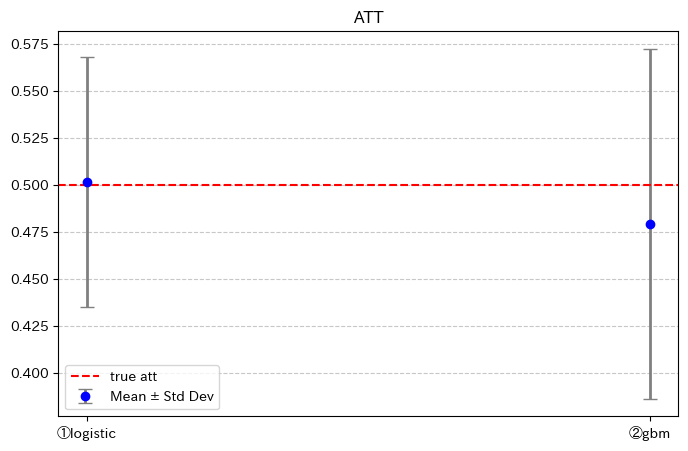

In [261]:
# 凡例を設定
categories = ['①logistic', '②gbm']

# 比較結果を描画
plt.figure(figsize=(8, 5))
# 点とエラーバーを描画
plt.errorbar(categories, avg_att_hat_list,yerr=std_att_hat_list,fmt='o', color='blue', ecolor='gray', elinewidth=2, capsize=5, label='Mean ± Std Dev')
plt.title('ATT')
plt.axhline(y=true_att, color='red', linestyle='--', label='true att')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
# plt.ylim(0, 1)

plt.show()

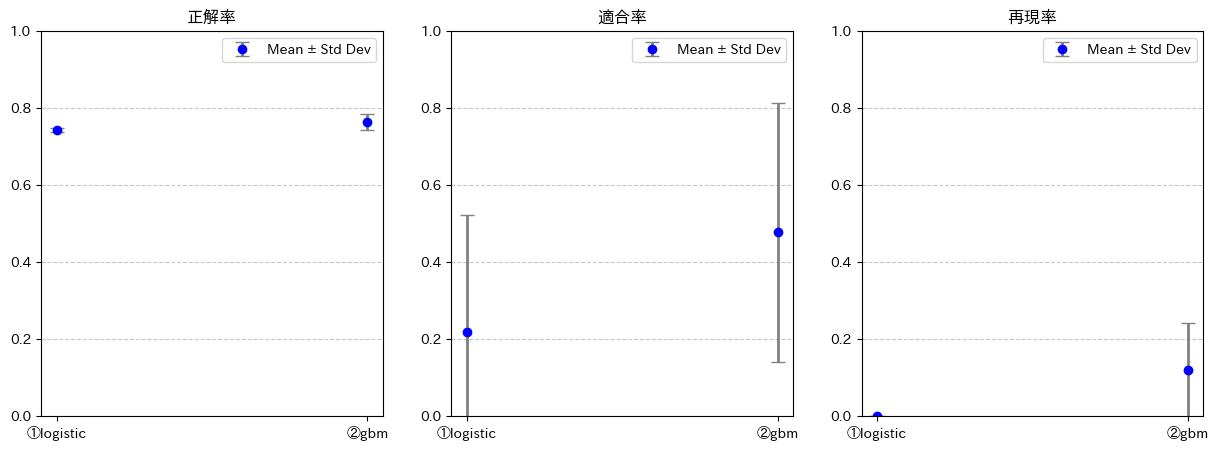

In [262]:
# 凡例を設定
categories = ['①logistic', '②gbm']

# 比較結果を描画
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# 点とエラーバーを描画
axes[0].errorbar(categories, avg_accuracy_list,yerr=std_accuracy_list,fmt='o', color='blue', ecolor='gray', elinewidth=2, capsize=5, label='Mean ± Std Dev')
axes[0].set_title('正解率')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend()
axes[0].set_ylim(0, 1)

axes[1].errorbar(categories, avg_precision_list,yerr=std_precision_list,fmt='o', color='blue', ecolor='gray', elinewidth=2, capsize=5, label='Mean ± Std Dev')
axes[1].set_title('適合率')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend()
axes[1].set_ylim(0, 1)

axes[2].errorbar(categories, avg_recall_list,yerr=std_recall_list,fmt='o', color='blue', ecolor='gray', elinewidth=2, capsize=5, label='Mean ± Std Dev')
axes[2].set_title('再現率')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].legend()
axes[2].set_ylim(0, 1)

plt.show()

## 傾向スコアモデルの良し悪しとATTの推定精度の違いを考える

In [299]:
i = 30
data_size = 10000
true_att = 0.5
df = generate_data_for_ps_matching(random_seed=i, data_size=data_size, true_att=true_att)

df['pscore_by_logi'] = return_pscore_by_logistic_regression(df=df)
evaluate_dict = evaluate_ps_model(df=df, pscore_column='pscore_by_logi')
print('ロジスティック回帰精度')
display(evaluate_dict)

df['pscore_by_gbm'] = return_pscore_by_gbm(df=df)
evaluate_dict = evaluate_ps_model(df=df, pscore_column='pscore_by_gbm')
print('勾配ブースティング木精度')
display(evaluate_dict)

ロジスティック回帰精度


{'AUC': 0.6123471551850226,
 'Log Loss': 0.5558270615505166,
 'Accuracy': 0.742,
 'Precision': 0.0,
 'Recall': 0.0,
 'PR-AUC': 0.3369866363976939}

勾配ブースティング木精度


{'AUC': 0.8089769426858062,
 'Log Loss': 0.45624917847122043,
 'Accuracy': 0.7848,
 'Precision': 0.7336244541484717,
 'Recall': 0.26046511627906976,
 'PR-AUC': 0.6166231267423555}

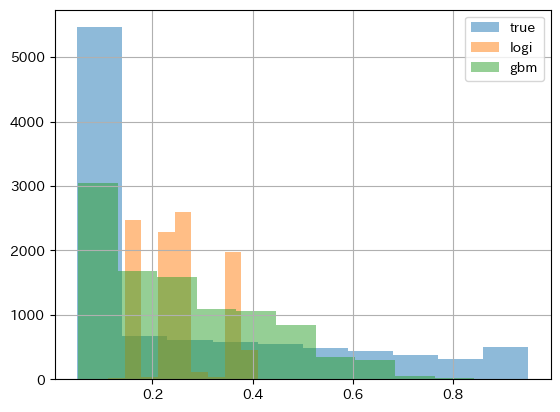

In [300]:
df['true_ps'].hist(alpha=0.5, label='true')
df['pscore_by_logi'].hist(alpha=0.5, label='logi')
df['pscore_by_gbm'].hist(alpha=0.5, label='gbm')
plt.legend()

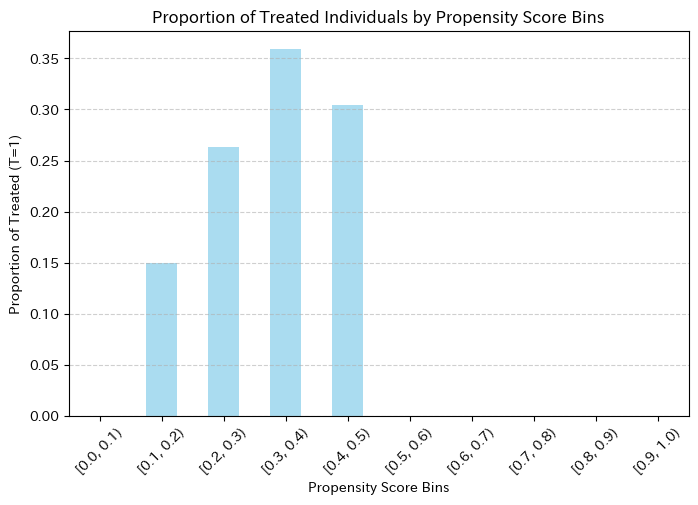

In [301]:
# ps_col = 'true_ps'
ps_col = 'pscore_by_logi'
bin_width = 0.1

# 傾向スコアをビン（区間）に分ける
bins = np.arange(0, 1 + bin_width, bin_width)
df['ps_bin'] = pd.cut(df[ps_col], bins=bins, right=False)

# 各ビンごとの処置群（T=1）の割合を計算
ps_summary = df.groupby('ps_bin')['T'].mean()

# グラフの作成
fig, ax = plt.subplots(figsize=(8, 5))
ps_summary.plot(kind='bar', color='skyblue', alpha=0.7, ax=ax)

# 軸ラベルとタイトル
ax.set_xlabel("Propensity Score Bins")
ax.set_ylabel("Proportion of Treated (T=1)")
ax.set_title("Proportion of Treated Individuals by Propensity Score Bins")
ax.set_xticklabels(ps_summary.index, rotation=45)

# グリッド追加
ax.grid(axis='y', linestyle='--', alpha=0.6)

# グラフを表示
plt.show()

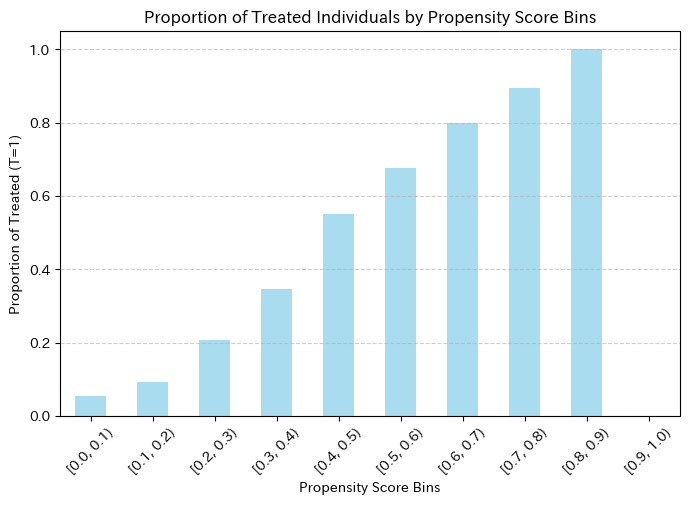

In [302]:
# ps_col = 'true_ps'
ps_col = 'pscore_by_gbm'
bin_width = 0.1

# 傾向スコアをビン（区間）に分ける
bins = np.arange(0, 1 + bin_width, bin_width)
df['ps_bin'] = pd.cut(df[ps_col], bins=bins, right=False)

# 各ビンごとの処置群（T=1）の割合を計算
ps_summary = df.groupby('ps_bin')['T'].mean()

# グラフの作成
fig, ax = plt.subplots(figsize=(8, 5))
ps_summary.plot(kind='bar', color='skyblue', alpha=0.7, ax=ax)

# 軸ラベルとタイトル
ax.set_xlabel("Propensity Score Bins")
ax.set_ylabel("Proportion of Treated (T=1)")
ax.set_title("Proportion of Treated Individuals by Propensity Score Bins")
ax.set_xticklabels(ps_summary.index, rotation=45)

# グリッド追加
ax.grid(axis='y', linestyle='--', alpha=0.6)

# グラフを表示
plt.show()

In [318]:
before_smd_df = compute_smd(df)
matched_df = return_matched_df(df=df, pscore_column='true_ps')

display(matched_df[matched_df['T']==1].head())
display(matched_df[matched_df['T']==0].head())

,X1,X2,X3,X4,X5,T,Y,true_ps,Y0,Y1,pscore_by_logi,pscore_by_gbm,ps_bin
0,0.418555,3.577151,1,0.308978,1,1,1.319653,0.816415,0.819653,1.319653,0.372462,0.636163,"[0.6, 0.7)"
1,-2.277320,1.666238,1,-0.759443,0,1,2.570574,0.392395,2.070574,2.570574,0.249254,0.203875,"[0.2, 0.3)"
2,0.184271,2.161425,1,0.141400,1,1,0.779524,0.814905,0.279524,0.779524,0.372402,0.595156,"[0.5, 0.6)"
3,-0.716537,5.278991,0,-0.461101,1,1,0.224048,0.644848,-0.275952,0.224048,0.265899,0.308902,"[0.3, 0.4)"
4,0.849343,1.559681,1,0.897004,0,1,5.810282,0.592579,5.310282,5.810282,0.243352,0.475144,"[0.4, 0.5)"


,X1,X2,X3,X4,X5,T,Y,true_ps,Y0,Y1,pscore_by_logi,pscore_by_gbm,ps_bin
2580,0.433211,3.558938,0,0.220024,1,0,2.319404,0.818607,2.319404,2.819404,0.265731,0.509699,"[0.5, 0.6)"
2581,1.603356,0.807015,1,1.075406,0,0,2.928340,0.392444,2.928340,3.428340,0.237598,0.388290,"[0.3, 0.4)"
2582,-1.373713,2.745037,0,-0.911517,1,0,1.723580,0.812395,1.723580,2.223580,0.265743,0.389050,"[0.3, 0.4)"
2583,0.421874,4.166196,0,0.682805,1,0,2.318667,0.644901,2.318667,2.818667,0.276032,0.400563,"[0.4, 0.5)"
2584,-1.063541,4.045160,0,-0.742019,1,0,0.883016,0.592600,0.883016,1.383016,0.264834,0.418344,"[0.4, 0.5)"


真の傾向スコアでマッチングした場合(1:1)、Y0の値が全然揃っていないことがわかる

## 目的変数の過去の値が揃っているかどうかが良さそう

In [345]:
i = 30
data_size = 10000
true_att = 0.5
df = generate_data_for_ps_matching(random_seed=i, data_size=data_size, true_att=true_att)

df['pscore'] = return_pscore_by_logistic_regression(df=df)
matched_df = return_matched_df(df=df, pscore_column='pscore')
att_hat = return_att(matched_df)
print(f'ATT: {att_hat:.3f}')

me_y_past = (np.array(matched_df[matched_df['T']==1]['Y_past']) - np.array(matched_df[matched_df['T']==0]['Y_past'])).mean()
print(f'Y_past平均誤差: {me_y_past:.3f}')

ATT: 0.523
Y_past平均誤差: 0.022


In [346]:
i = 30
data_size = 10000
true_att = 0.5
df = generate_data_for_ps_matching(random_seed=i, data_size=data_size, true_att=true_att)

df['pscore'] = return_pscore_by_gbm(df=df)
matched_df = return_matched_df(df=df, pscore_column='pscore')
att_hat = return_att(matched_df)
print(f'ATT: {att_hat:.3f}')

me_y_past = (np.array(matched_df[matched_df['T']==1]['Y_past']) - np.array(matched_df[matched_df['T']==0]['Y_past'])).mean()
print(f'Y_past平均誤差: {me_y_past:.3f}')

ATT: 0.390
Y_past平均誤差: -0.113
